# BIO-ENG456: Controlling behavior in animalsand robots
Group: 8\
Lorenzo GERMINI\
Mathias NURIS-SOUQUET\
Hila VARDI

Date: 25.05.2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA 
from scipy.signal import butter, filtfilt

#one can add this library on this link https://pypi.org/project/behavelet/
#or directly running "pip install behavelet" on Conda or Python
from behavelet import wavelet_transform

# K-MEAN
from sklearn.cluster import KMeans

# GMM clustering
from sklearn import mixture

#correlation
import seaborn as sns

# logistic regression and MLP
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from collections import Counter

C:\Users\Haha\anaconda3\lib\site-packages\behavelet\morlet.py:26: UserWarning: CuPy was not found, so GPU functionality is unavailable. See https://github.com/cupy/cupy#installation for installation instructions
  warnings.warn('CuPy was not found, so GPU functionality is unavailable. '


# 1.  Loading the behavioural/neural data

In [2]:
beh_data_dir = "data/COBAR_behaviour_incl_manual_corrected.pkl"
beh_df = pd.read_pickle(beh_data_dir)

In [3]:
neural_data_dir = beh_data_dir = "data/COBAR_neural.pkl"
neural_df = pd.read_pickle(neural_data_dir)

# 2. Data Preprocessing

### A. Noise reduction

In [17]:
def butter_lowpass_filter(data, cutoff, fs, order):
    """
    Apply a butterworth (lowpass) filter on the data for denoising according to the parameters given.
    Parameters
    ----------
    data : DataFrame
         The data to which you want to apply the noise filter.
    cutoff : float
        Cutoff frequency for your butterworth filter.
    fs : float
        Sampling frequency.
    order : integer
        Order of the filter.
    Returns
    -------
    reduced : numpy matrix
        Numpy matrix with denoised data according to the parameters given.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

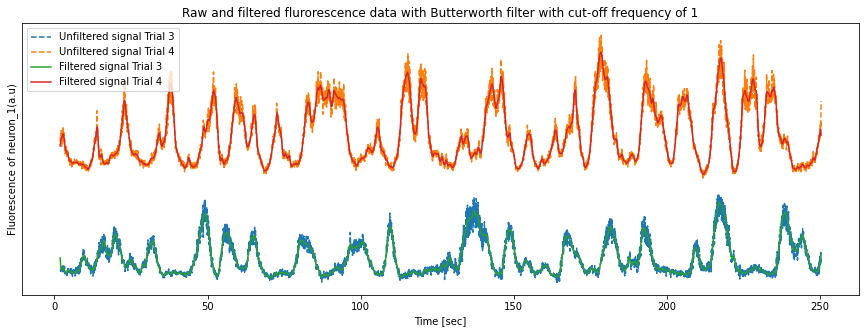

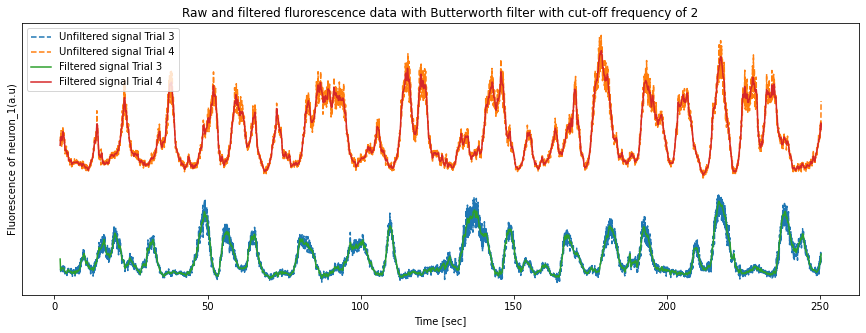

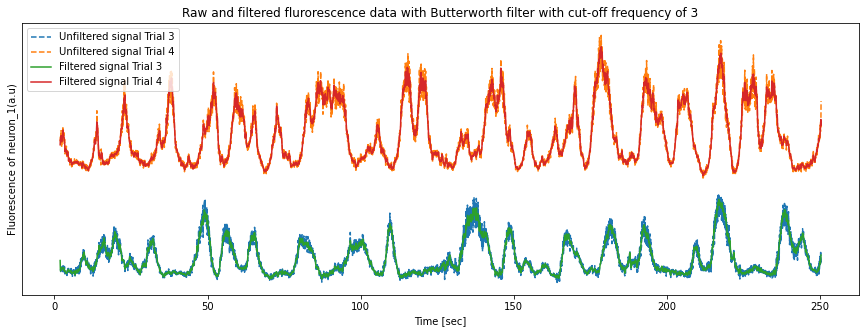

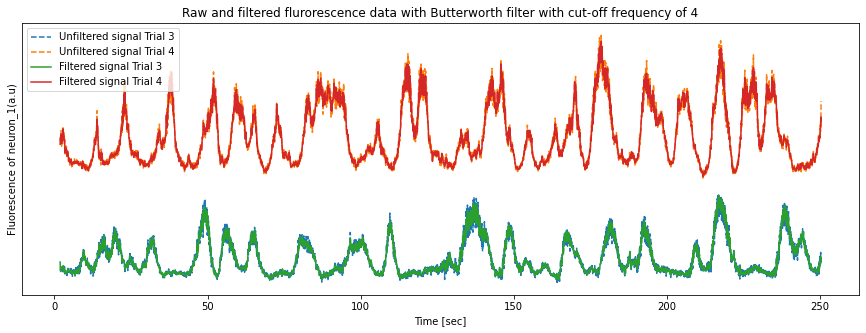

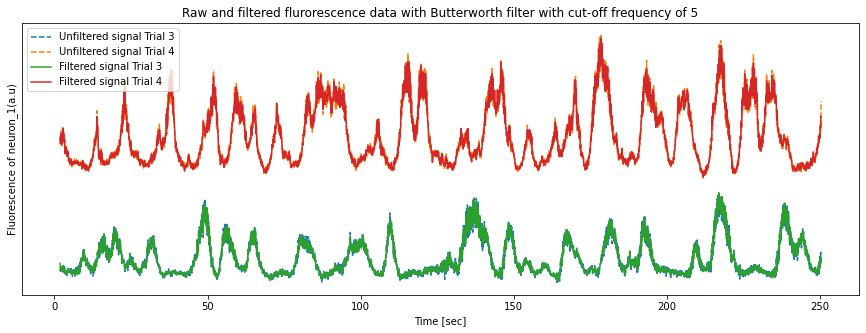

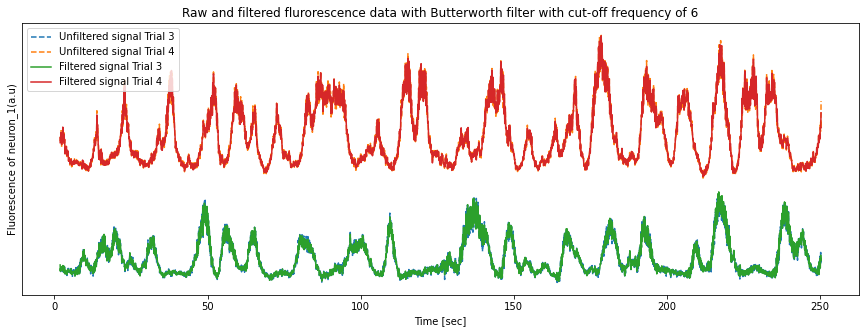

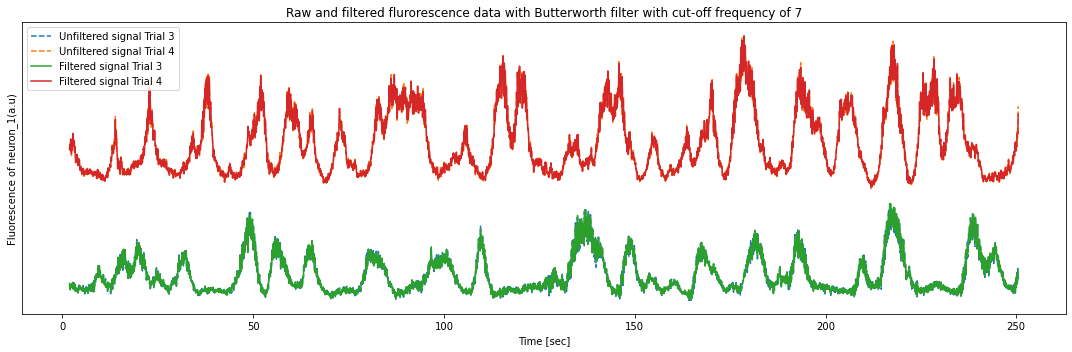

In [18]:
#plots to justify parameters choice for the filter for the neural data
filtered_neural_df = neural_df.copy(deep=True)
neural_signals_neuron_1 = neural_df["neuron_1"]
time = neural_df["t"]

#these parameters are fixed
fs=16.0
order=2

#optional interactive plot to enable the zooming in
#%matplotlib notebook
#import mpld3
#mpld3.enable_notebook()

#define range of cut-off frequencies to explore for the neural data
rangefcut=range(1,8,1)
ytick = []

time = neural_df["t"]
for cutoff in rangefcut:
    fig, ax = plt.subplots(figsize = (15,5))
    for i in range(3,5,1):
        # look at two trials at the same time for more robust results
        t=time[time.index.get_level_values("Trial")==i]
        neural_signals_neuron_1_trial_i = neural_signals_neuron_1[neural_df.index.get_level_values("Trial")==i]+i*1500
        plt.plot(t, neural_signals_neuron_1_trial_i, alpha = 1, linestyle='dashed', label=f'Unfiltered signal Trial {i}')
        ytick.append(neural_signals_neuron_1_trial_i.iloc[0] + i*1500)
        plt.xlabel('Time [sec]')

    #superimpose filtered data
    filtered_neural_df_neuron_1 = butter_lowpass_filter(neural_df['neuron_1'], cutoff, fs, order) #this line has to be used with the following one
    filtered_neural_df.neuron_1=filtered_neural_df_neuron_1
    filtered_neural_signals_neuron_1 = filtered_neural_df['neuron_1']
    time=filtered_neural_df["t"]
    for i in range(3,5,1):
        filtered_neural_signals_neuron_1_trial_i = filtered_neural_signals_neuron_1[filtered_neural_df.index.get_level_values("Trial")==i]+i*1500
        t=time[time.index.get_level_values("Trial")==i]
        plt.plot(t, filtered_neural_signals_neuron_1_trial_i, alpha = 1, label=f'Filtered signal Trial {i}')
        ytick.append(filtered_neural_signals_neuron_1_trial_i.iloc[0] + i*1500)
        plt.xlabel('Time [sec]')
        plt.title(f"Raw and filtered flurorescence data with Butterworth filter with cut-off frequency of {cutoff}")
        plt.legend(loc='upper left')
        plt.ylabel('Fluorescence of neuron_1(a.u)')
        
        plt.yticks([])
plt.tight_layout()
plt.show()
fig.savefig('report_images/rangebuttfilt_neuron_1.png')

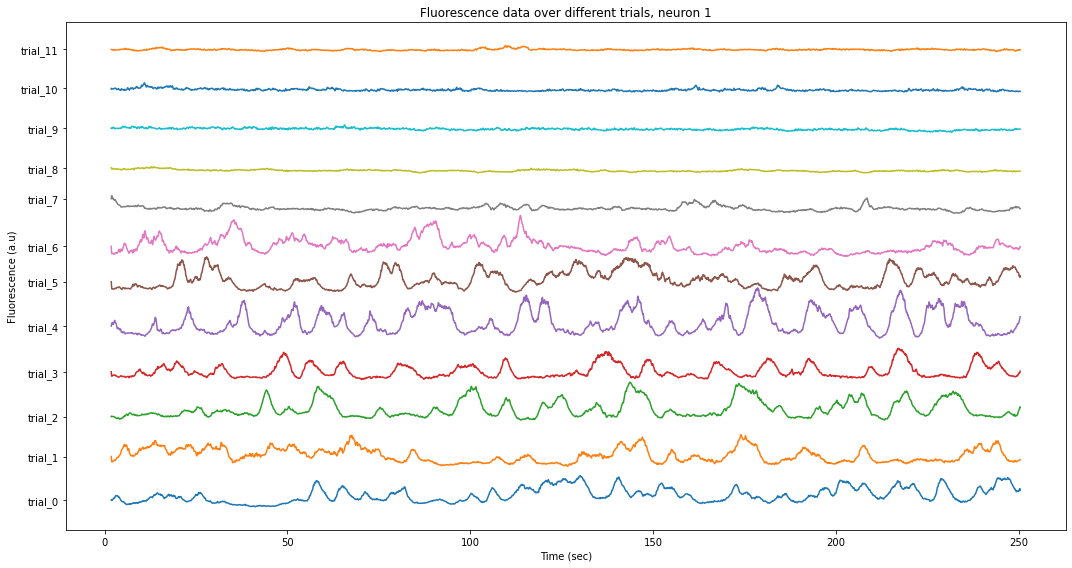

In [19]:
#plot filtered neural data for neuron_1 for all the trials for visual comparison with the raw plotting
filtered_neural_df = neural_df.copy(deep=True) 
fs=16.0
order=2
cutoff=2.5 #chosen value based on previous results

#apply filter for plotting
filtered_neural_df_neuron_1 = butter_lowpass_filter(neural_df['neuron_1'], cutoff, fs, order)
filtered_neural_df.neuron_1=filtered_neural_df_neuron_1
filtered_neural_signals_neuron_1 = filtered_neural_df['neuron_1']

# We construct a 3x3 matrix whose elements will be subplots depending on the column and row number they span
fig, ax1 = plt.subplots(figsize = (15,8))

ytick = []
for i in np.arange(12):   
    filtered_neural_signals_neuron_1_trial_i = filtered_neural_signals_neuron_1[neural_df.index.get_level_values("Trial")==i]
    #ax1.plot(neural_df["t"].iloc[:380], i*1500 + neural_signals_neuron_1_trial_i.iloc[:380], label = 'trial_' + str(i))
    ax1.plot(filtered_neural_df["t"].iloc[:4039], i*1500 + filtered_neural_signals_neuron_1_trial_i.iloc[:4039], label = 'trial_' + str(i))
    ytick.append(filtered_neural_signals_neuron_1_trial_i.iloc[0] + i*1500)
    
ax1.set_ylabel('Fluorescence (a.u)')
ax1.set_xlabel('Time (sec)')
ax1.set_title('Fluorescence data over different trials, neuron 1')

ax1.set_yticks(np.array(ytick))
neuron_names = ['trial_' + str(i) for i in range(12)]
ax1.set_yticklabels(neuron_names)


plt.tight_layout()
plt.show()
fig.savefig('report_images/filtered_fluo_neurone1.png')

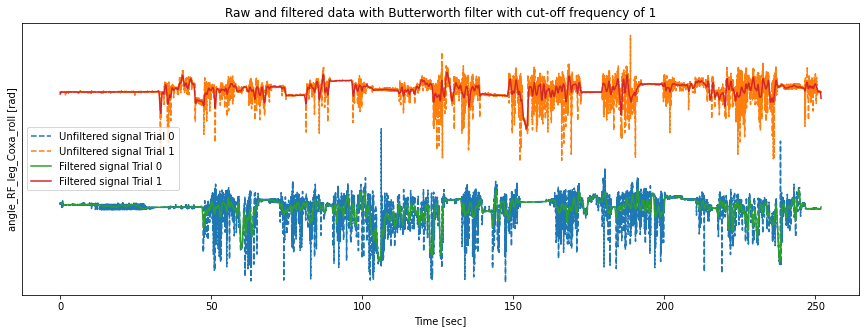

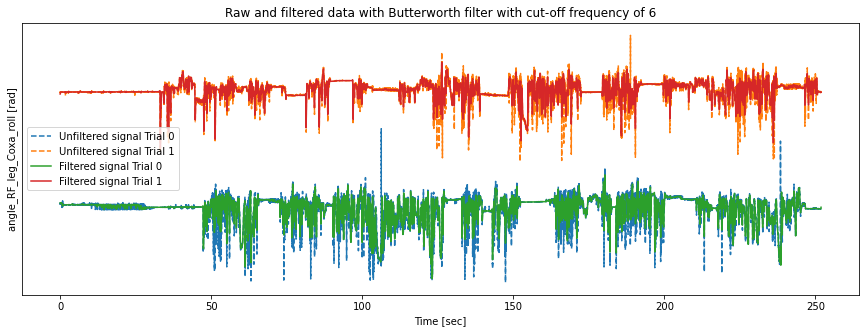

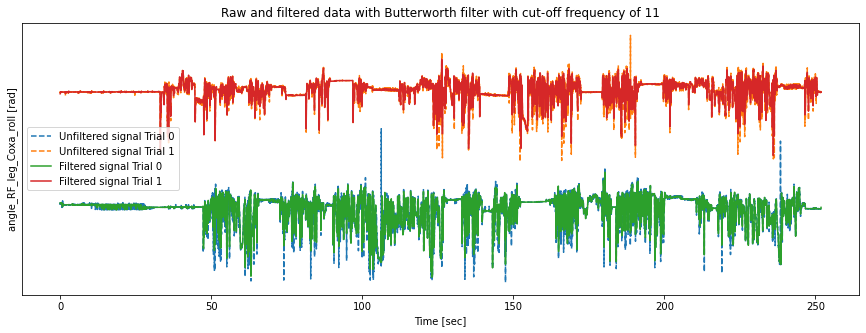

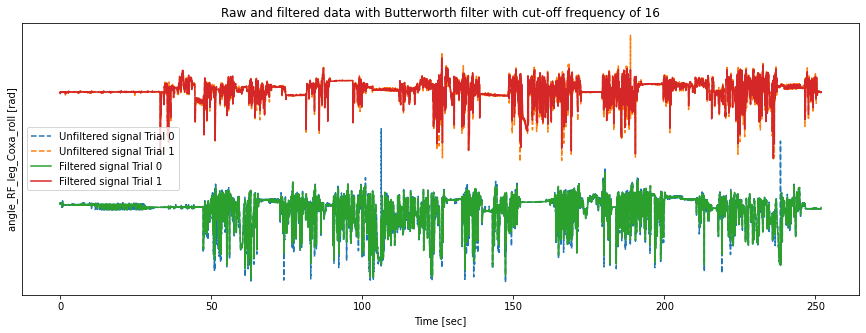

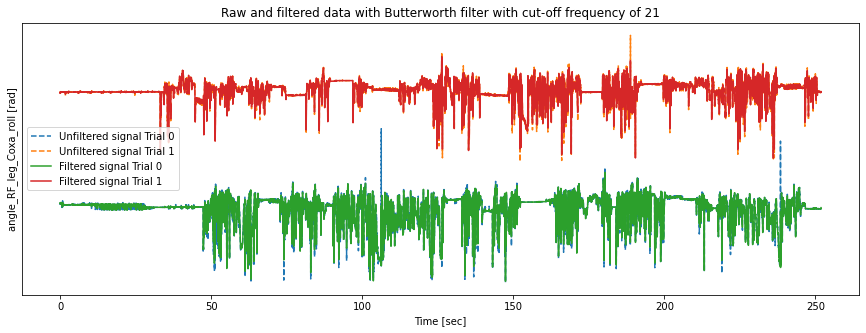

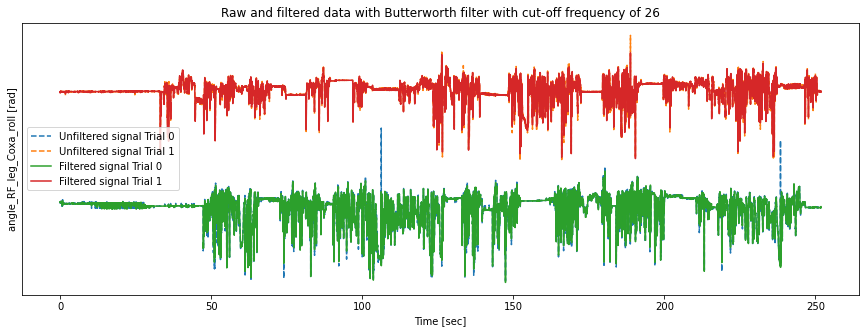

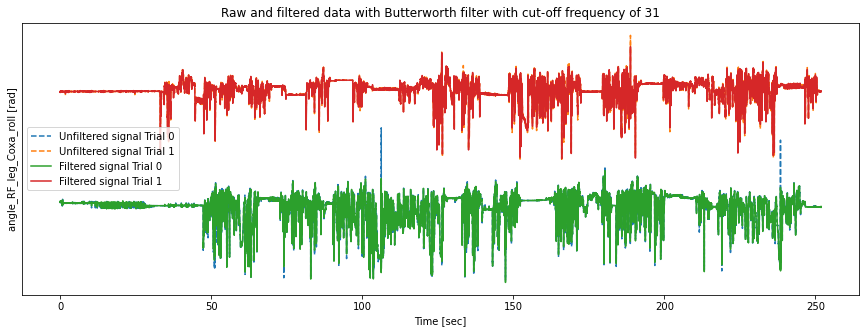

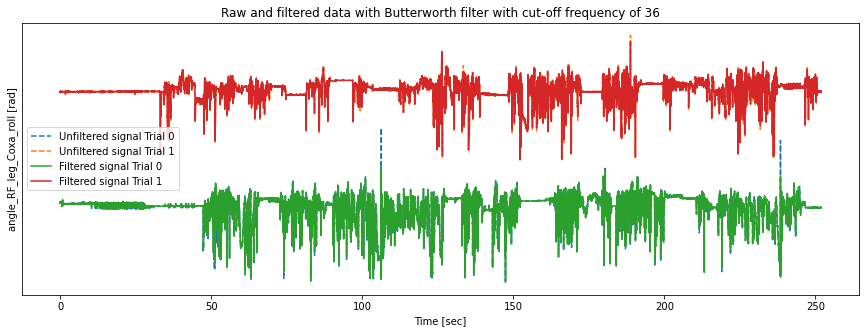

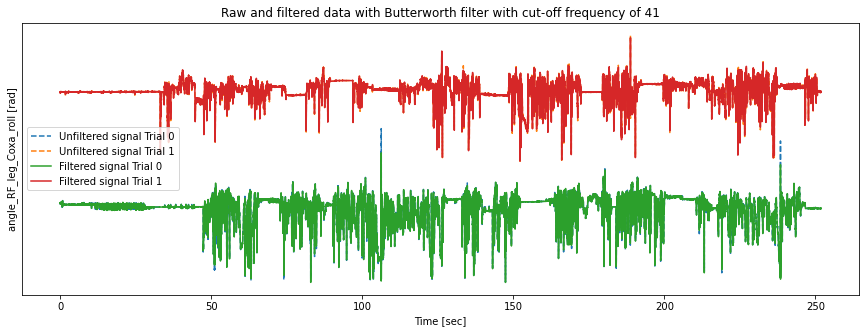

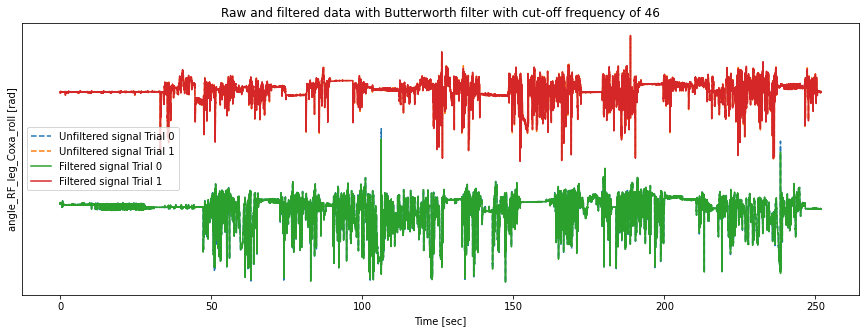

In [20]:
# plots to justify parameters choice for the filter for the behavioral data
filtered_beh_df = beh_df.copy(deep=True)

#these parameters are fixed
fs=100.0
order=2
#plot unifltered of one specific angle
angle_RF_leg_roll = beh_df["angle_RF_leg_Coxa_roll"]
time = beh_df["t"]

#interactive plot to enable the zooming in
#%matplotlib notebook
#import mpld3
#mpld3.enable_notebook()

#define range of cut-off frequencies to explore for the behavioral data
rangefcut=range(1,49,5)
for cutoff in rangefcut:
    fig, ax = plt.subplots(figsize = (15,5))
    for i in range(2):
        
        # look at two trials at the same time for more robust resultsfl
        y = angle_RF_leg_roll[angle_RF_leg_roll.index.get_level_values("Trial")==i]+3*i
        t=time[time.index.get_level_values("Trial")==i]
        plt.plot(t, y, alpha = 1, linestyle='dashed', label=f'Unfiltered signal Trial {i}')
        plt.xlabel('Time [sec]')
        plt.legend()
        
    #superimpose filtered data
    filtered_beh_df_anglerf = butter_lowpass_filter(beh_df["angle_RF_leg_Coxa_roll"], cutoff, fs, order)
    filtered_beh_df.angle_RF_leg_Coxa_roll=filtered_beh_df_anglerf
    filtered_angle_RF_leg_roll = filtered_beh_df["angle_RF_leg_Coxa_roll"]
    time = filtered_beh_df["t"]
    
    for i in range(2):
        y = filtered_angle_RF_leg_roll[filtered_angle_RF_leg_roll.index.get_level_values("Trial")==i]+3*i
        t=time[time.index.get_level_values("Trial")==i]
        plt.plot(t, y, alpha = 1, label=f'Filtered signal Trial {i}')
        plt.legend(loc='center left')
        plt.ylabel('angle_RF_leg_Coxa_roll [rad]')
        #plt.xlabel('Time [sec]')
        plt.title(f"Raw and filtered data with Butterworth filter with cut-off frequency of {cutoff}")
        plt.yticks([])
plt.show()
fig.savefig('report_images/rangebuttfilt_Coxa-roll.png')

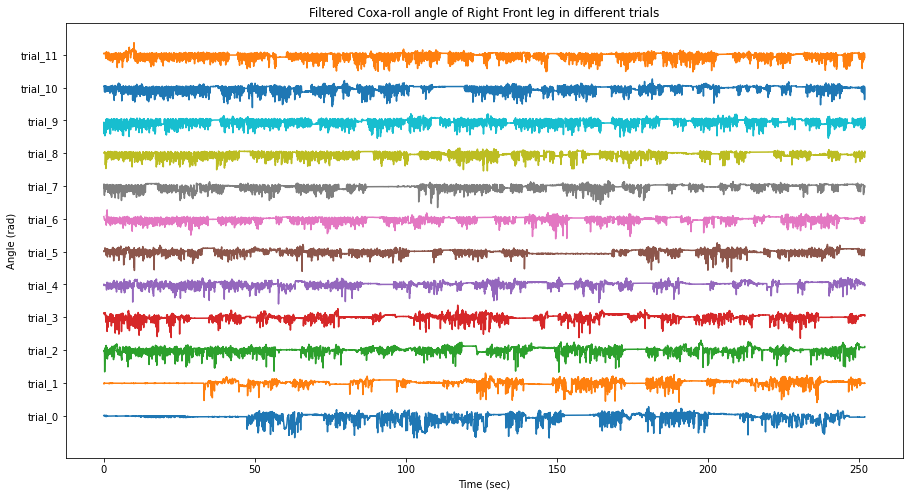

In [21]:
#plot  time traces of filtered angle_RF_leg_Coxa_roll across multiple trials to visually compare with plots of
#unfiltered data
filtered_beh_df = beh_df.copy(deep=True)
fs=100.0
order=2
cutoff=20 #chosen based on previous results


#plot unifltered of one specific angle
angle_RF_leg_roll = beh_df["angle_RF_leg_Coxa_roll"]
filtered_beh_df_anglerf = butter_lowpass_filter(beh_df["angle_RF_leg_Coxa_roll"], cutoff, fs, order)
filtered_beh_df.angle_RF_leg_Coxa_roll=filtered_beh_df_anglerf
filtered_angle_RF_leg_roll = filtered_beh_df["angle_RF_leg_Coxa_roll"]
time = filtered_beh_df["t"]

fig, ax = plt.subplots(figsize = (15,8))
ytick = []

for i in range(12):
    y = filtered_angle_RF_leg_roll[filtered_angle_RF_leg_roll.index.get_level_values("Trial")==i]+3*i
    t=time[time.index.get_level_values("Trial")==i]
    plt.plot(t, y, alpha = 1) 
    ytick.append(filtered_angle_RF_leg_roll.iloc[0] + i*3)

ax.set_yticks(np.array(ytick))
trial_names = ['trial_' + str(i) for i in range(12)]
ax.set_yticklabels(trial_names)
ax.set_ylabel('Angle (rad)')
ax.set_xlabel('Time (sec)')
ax.set_title('Filtered Coxa-roll angle of Right Front leg in different trials')
plt.show()
fig.savefig('report_images/w8_Coxa-roll.png')

In [22]:
#best parameters selected for filter for the behavioral data
fs=100.0
order=2
cutoff=20
filtered_beh_df = beh_df.copy(deep=True)#necessary to deep copy dataaframe
angl=beh_df.filter(regex="angle")
filtered_angl = butter_lowpass_filter(angl, cutoff, fs, order)
filtered_beh_df.iloc[:,2:44]=filtered_angl

##best parameters selected for filter for the neural data
filtered_neural_df = neural_df.copy(deep=True) 
fs=16.0
order=2
cutoff=2.5
neurons=neural_df.filter(regex="neuron")
filtered_neurons = butter_lowpass_filter(neurons, cutoff, fs, order)
filtered_neural_df.iloc[:,1:124]=filtered_neurons

filtered_neural_df = neural_dF_F(filtered_neural_df)
filtered_neural_df

t  neuron_0  neuron_1  neuron_2  \
Date   Genotype Fly Trial Frame                                             
210301 J1xCI9   1   0     0        1.846767  1.830262  2.302435  0.913503   
                          1        1.908333  1.896733  2.223851  0.915863   
                          2        1.969900  1.913865  2.196361  0.898505   
                          3        2.031467  1.874510  2.254948  0.856188   
                          4        2.093000  1.829596  2.342961  0.807146   
...                                     ...       ...       ...       ...   
                    11    4035   250.257500  2.437069  0.407765  3.851353   
                          4036   250.319067  2.403217  0.448867  3.802544   
                          4037   250.380600  2.407801  0.449155  3.788424   
                          4038   250.442167  2.478857  0.391827  3.878330   
                          4039   250.503733  2.599644  0.294782  4.069995   

                                 neuron_3  neuron_4  neuron_5  neuron_6  \
Date   Genotype Fly Trial Frame                                           
210301 J1xCI9   1   0     0      0.673424  0.507693  0.534641  0.236509   
                          1      0.671848  0.493673  0.499232  0.256947   
                          2      0.664598  0.482641  0.480229  0.269833   
                          3      0.656248  0.474498  0.475333  0.272971   
                          4      0.656803  0.469005  0.472947  0.271457   
...                                   ...       ...       ...       ...   
                    11    4035   6.076314  1.898427  1.288609  0.438098   
                          4036   6.119052  1.935560  1.366787  0.454012   
                          4037   6.119410  1.992323  1.448984  0.453758   
                          4038   6.055433  2.073192  1.518322  0.444656   
                          4039   5.925515  2.173827  1.578098  0.442154   

                                 neuron_7  neuron_8  ...  neuron_113  \
Date   Genotype Fly Trial Frame                      ...               
210301 J1xCI9   1   0     0      0.684245  0.588805  ...    1.076976   
                          1      0.655468  0.566063  ...    1.040678   
                          2      0.650144  0.549203  ...    1.008861   
                          3      0.660358  0.539477  ...    0.987256   
                          4      0.660709  0.538147  ...    0.976346   
...                                   ...       ...  ...         ...   
                    11    4035   4.608283  1.554365  ...    0.405355   
                          4036   4.642148  1.556720  ...    0.427632   
                          4037   4.652684  1.536832  ...    0.481182   
                          4038   4.582710  1.495086  ...    0.529576   
                          4039   4.433745  1.438210  ...    0.564194   

                                 neuron_114  neuron_115  neuron_116  \
Date   Genotype Fly Trial Frame                                       
210301 J1xCI9   1   0     0        0.768052    0.855806    1.114782   
                          1        0.731206    0.864005    1.142800   
                          2        0.700835    0.869347    1.150103   
                          3        0.681750    0.872432    1.129095   
                          4        0.673142    0.871986    1.090137   
...                                     ...         ...         ...   
                    11    4035     1.884477    0.786541    2.500893   
                          4036     1.969924    0.785018    2.515189   
                          4037     2.043410    0.785238    2.498330   
                          4038     2.112438    0.747801    2.455444   
                          4039     2.183506    0.665350    2.378206   

                                 neuron_117  neuron_118  neuron_119  \
Date   Genotype Fly Trial Frame                                       
210301 J1xCI9   1   0     0        2.053602    1.458494    2.

### B. Performing ΔF/F on neural data

In [5]:
#Δ𝐹/𝐹 = (F − Fb)/𝐹b , where Fb is the baseline fluorescence.
# return baselined neural data
def neural_dF_F(data):
    rlt_Df_f=data.copy()
    nb_neurons = np.size(data,1)
    
    for j in np.arange(nb_neurons-1): 
        baseline = data['neuron_' + str(j)].rolling(window=3).mean()
        rlt_Df_f['neuron_' + str(j)] = (data['neuron_' + str(j)]-abs(baseline.min()))/abs(baseline.min())
    return rlt_Df_f

#final step of pre-processing : performing Delta_F/F on denoised signals
filtered_neural_df = neural_dF_F(filtered_neural_df)

In [32]:
# Global Parameters
nb_trials = 12
frames_in_trial = 4040

# behavior labels
behaviors = ['resting', 'walking', 'anterior_grooming', 'abdominal_pushing', 'posterior_grooming']
# leg joint labels
joints = ['Coxa', 'Coxa_roll', 'Coxa_yaw', 'Femur', 'Femur_roll', 'Tibia', 'Tarsus']

# time vector
t = filtered_neural_df["t"]
time = t[t.index.get_level_values("Trial")==0]
time_offset = time.iloc[-1]
for i in range(nb_trials-1):
    time_trial_i = t[t.index.get_level_values("Trial")==(i+1)]
    time = pd.concat([time, time_trial_i+time_offset], axis=0)
    time_offset = time_offset + time_trial_i.iloc[-1]

### C. Downsampling manual labels

In [7]:
# these two functions are just wrappers around the numpy functions to apply them across dimension 0 only
def reduce_mean(values):
    return np.mean(values, axis=0)
def reduce_std(values):
    return np.std(values, axis=0)
def reduce_behaviour(values):
    """
    this is just a sketch for how to reduce behavioural classes. 
    It picks whatever behaviour occurs the most.
    The function handles the case when two behaviours are equally likely thanks to the chosen treshold,
    and assures, given that the values are always 6 or 7, that if 4/6 or 4/7 behaviour frames are not labelled the same way
    returns nan and the data is excluded.
    """
    unique_values, N_per_unique = np.unique(values, return_counts=True)
    i_max = np.argmax(N_per_unique)

    #threshold = 0.75
    threshold = 4 #this treshold shows more robustness then using the 3/4
    for idx, unique_value in enumerate(unique_values):
        if N_per_unique[idx] > threshold:
        #if N_per_unique[idx] > threshold * len(values):
            return unique_value
    return "nan"
# threshold = 0.75
# for idx, unique_value in enumerate(unique_values):
#     if N_per_unique[idx] > threshold * len(values):
#          return unique_value
#return None

def reduce_during_2p_frame(twop_index, values, function=reduce_mean):
    """
    Reduces all values occuring during the acquisition of a
    two-photon imaging frame to a single value using the `function` given by the user.
    Parameters
    ----------
    twop_index : numpy array
        1d array holding frame indices of one trial.
    values : numpy array
        Values upsampled to the frequency of ThorSync,
        i.e. 1D numpy array of the same length as
        `frame_counter` or 2D numpy array of the same length.
    function : function
        Function used to reduce the value,
        e.g. np.mean for 1D variables
    Returns
    -------
    reduced : numpy array
        Numpy array with value for each two-photon imaging frame.
    """
    
    if len(twop_index) != len(values):
        raise ValueError("twop_index and values need to have the same length.")
    if len(values.shape) == 1:
        values = np.expand_dims(values, axis=1)
        squeeze = True
    else:
        squeeze = False
    N_samples, N_variables = values.shape
    
    index_unique = np.unique(twop_index)
    index_unique = np.delete(index_unique, index_unique==-9223372036854775808)
    
    dtype = values.dtype
    if np.issubdtype(dtype, np.number):
        dtype = np.float
    else:
        dtype = np.object
    reduced = np.empty((len(index_unique), N_variables), dtype=dtype)

    for i, index in enumerate(index_unique):
        reduced[i] = function(values[twop_index==index, :])

    return np.squeeze(reduced) if squeeze else reduced

# 3. Investigate clustering of neurons' activity: find neurons that correlate with each other

This section aims at finding neurons that activate at similar times. This is done by doing a Principal Component Analysis (PCA) followed by unsupervised clustering. The clustering is then evaluated using inter-neuron correlation.

### A. PCA 

In [18]:
# Functions required for PCA 

# standardize the data
def standardize(data):
    Feature_scaler = sklearn.preprocessing.StandardScaler().fit(data)
    return sklearn.preprocessing.scale(data)

# apply PCA:  
# input samples: neurons
# input features: time samples
def PCA_temporal(data_norm, time, plot=False):

    pca = PCA(n_components=27)
    data_new = pca.fit_transform(data_norm.T)
    print('Variance explained by first 27 pricipal components:')
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_))
    
    if plot:
        #plot loadings
        fig, ax = plt.subplots()
        loadings = pd.DataFrame(pca.components_[0:2].T, columns=['PC1', 'PC2'])
        plt.plot(time, loadings['PC1'], label = 'PC1', alpha=0.5)
        plt.plot(time, loadings['PC2'], label = 'PC2', alpha=0.5)
        plt.title('PCA Loadings of Neural Activity')
        plt.xlabel('Time point [s]')
        plt.ylabel('PCA weight')
        plt.legend()
        plt.show()
        fig.savefig('report_images/pca_neuro_temporal_loadings.png')
        
        fig, ax = plt.subplots()
        #scatter plot of first two components
        plt.scatter(data_new[:,0], data_new[:,1], alpha = 0.5) 
        plt.title('PCA Projected Neurons')
        plt.xlabel('PCA component 1 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[0]))
        plt.ylabel('PCA component 2 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[1]))
        plt.show()
        fig.savefig('report_images/pca_neuro_temporal_scatter.png')
        
    return data_new, pca

Variance explained by first 27 pricipal components:
[0.27332419 0.26424122 0.06765547 0.03619374 0.0326937  0.0254746
 0.02292318 0.01734588 0.01707517 0.01548904 0.01295125 0.01225217
 0.01175105 0.01067085 0.00938811 0.00884932 0.00829768 0.00770559
 0.00727797 0.00614932 0.00559425 0.00521567 0.00487156 0.00450561
 0.00439312 0.0041724  0.00379577]
0.9002578804798497


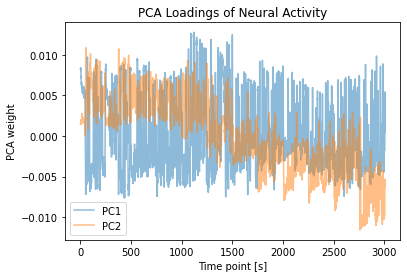

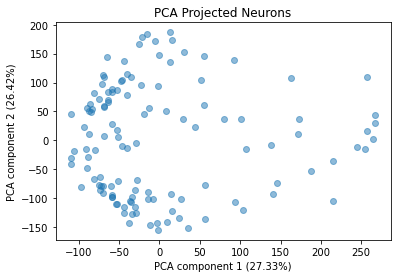

In [19]:
# PCA implementation (all trials are used as data)
X = filtered_neural_df.filter(regex="neuron")

X_norm = standardize(X)
X_new, pca = PCA_temporal(X_norm, time, plot=True)


### B. clustering
After the dimension reduction done with the PCA, the neurons can be clustered. These clusters represent neurons that have similar signals.

In [10]:
# cluster data using kmeans
# returns the classes and class names
def kmeans_cluster(data, nb_clusters, plot=False):
    
    #fit kmeans
    kmeans = KMeans(n_clusters=nb_clusters, init='random', n_init=1, verbose=0)
    kmeans.fit(data)
    labels = kmeans.labels_
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of KMEANS clusters
        fig, ax = plt.subplots()
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('feature 1')

        plt.ylabel('feature 2')
        plt.title('KMEANS clustering')
        plt.legend(class_names)
        plt.show()
        fig.savefig('report_images/cluster_kmeans.png')
    
    return labels, class_names

# cluster data using GMMs
# returns the classes and class names
def GMM_cluster(data, nb_components, plot=False):
    
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=nb_components, covariance_type='full').fit(data)
    
    labels = gmm.predict(data)
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of GMM clusters
        fig, ax = plt.subplots()
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('feature 1')

        plt.ylabel('feature 2')
        plt.title('GMM clustering')
        plt.legend(class_names)
        plt.show()
        fig.savefig('report_images/cluster_GMM.png')
        
    return labels, class_names

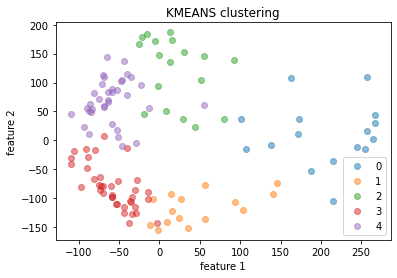

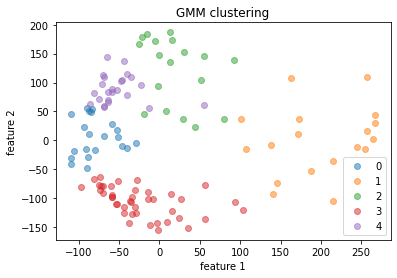

In [11]:
kmeans_labels, kmeans_names = kmeans_cluster(X_new, nb_clusters=5, plot=True)
GMM_labels, GMM_names = GMM_cluster(X_new, nb_components=5, plot=True)

### C. Neural activity of neurons from the same and different clusters

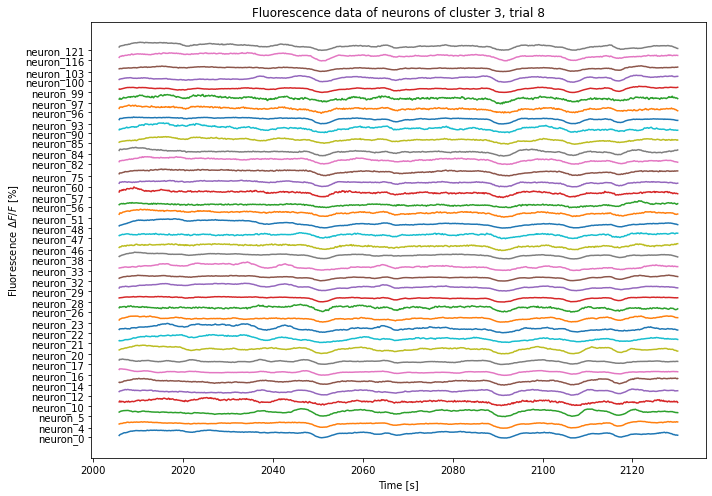

In [12]:
# compare neuronal activity of neurons of the same cluster: trial 8 (first half)
trial = 8
frame_i = int(frames_in_trial*(trial))
frame_f = int(frames_in_trial*(trial+0.5))

fig, ax = plt.subplots(figsize = (10,7))

ytick = []
neurons_cluster = np.where(kmeans_labels == kmeans_names[3])[0]
for i,neuro_id in enumerate(neurons_cluster): 
    neural_signals_neuron_i = X_norm[:,neuro_id]
    #plt.plot(time[time.index.get_level_values("Trial")==8], i*5 + neural_signals_neuron_i[4040*8:4040*9], label = 'neuron_' + str(neuro_id))
    plt.plot(time.iloc[frame_i:frame_f], i*5 + neural_signals_neuron_i[frame_i:frame_f], label = 'neuron_' + str(neuro_id))
    
    #frames_in_trial
    ytick.append(i*5 + neural_signals_neuron_i[0])
    
plt.ylabel('Fluorescence $\Delta F/F$ [%]')
plt.xlabel('Time [s]')
plt.title('Fluorescence data of neurons of cluster 3, trial 8')

plt.yticks(np.array(ytick))
neuron_names = ['neuron_' + str(i) for i in neurons_cluster]
ax.set_yticklabels(neuron_names)

plt.tight_layout()
plt.show()
fig.savefig('report_images/cluster3_signal.png')


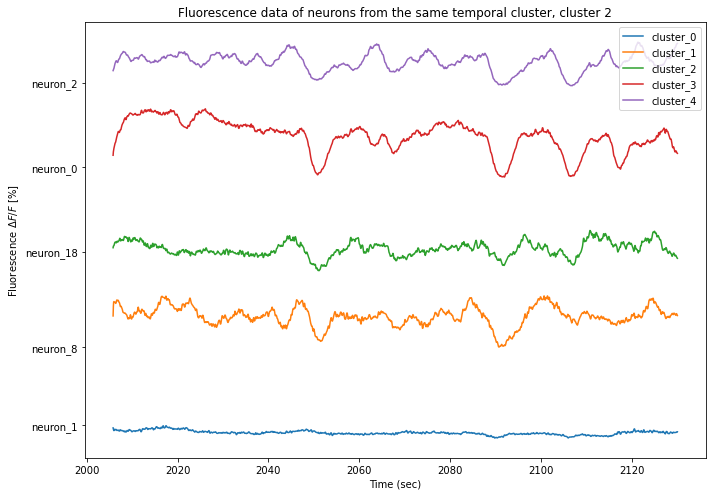

In [13]:
# compare neuronal activity of neurons of different clusters: trial 8
fig, ax = plt.subplots(figsize = (10,7))

ytick = []
neuron_names = []
for i in range(len(kmeans_names)):
    neurons_cluster = np.where(kmeans_labels == kmeans_names[i])[0]
    neural_signals_neuron_i = X_norm[:,neurons_cluster[0]]
    #plt.plot(time[time.index.get_level_values("Trial")==8], i*5 + neural_signals_neuron_i[4040*8:4040*9], label = 'cluster_' + str(i))
    plt.plot(time.iloc[frame_i:frame_f], i*5 + neural_signals_neuron_i[frame_i:frame_f], label = 'cluster_' + str(i))
    
    ytick.append(i*5 + neural_signals_neuron_i[0])
    neuron_names.append('neuron_' + str(neurons_cluster[0]))
    
plt.ylabel('Fluorescence $\Delta F/F$ [%]')
plt.xlabel('Time (sec)')
plt.title('Fluorescence data of neurons from the same temporal cluster, cluster 2')

ax.set_yticks(np.array(ytick))
ax.set_yticklabels(neuron_names)
plt.legend()

plt.tight_layout()
plt.show()
fig.savefig('report_images/clusters_diff_signal.png')

### D. Correlation
To evaluate the similarity between the signals of neurons from the same cluster, we can find their correlation coefficients.

In [14]:
# plot correlation coefficient of given data
def plot_correlation_coeff(data, title, filename):
    #Set up the matplotlib figure
    fig, ax = plt.subplots(figsize = (15,10))

    #Compute the correlation matrix
    correlation = data

    corr = correlation.corr()

    #Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    #Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    #Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.xlabel('neuron id')
    plt.ylabel('neuron id')
    plt.title(title)
    plt.show()
    fig.savefig('report_images/'+filename+'.png')

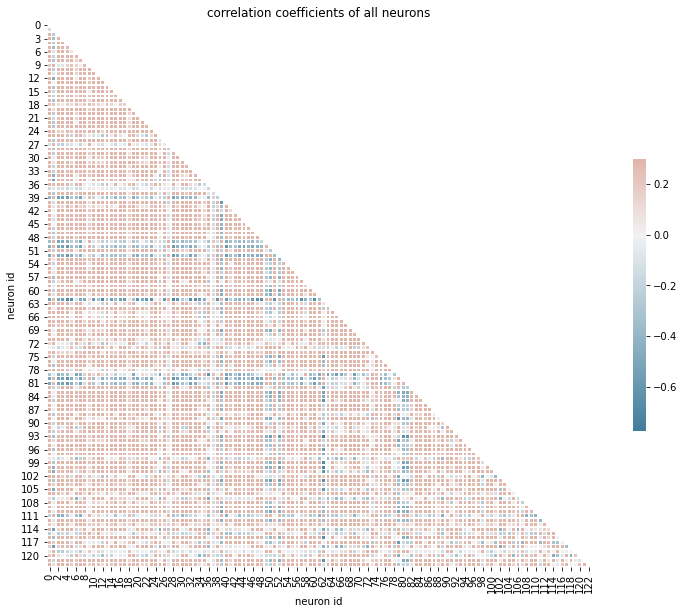

In [15]:
# correlation coefficient of all the neurons
plot_correlation_coeff(pd.DataFrame(data=X_norm), title='correlation coefficients of all neurons', filename='corr_all_neurons')

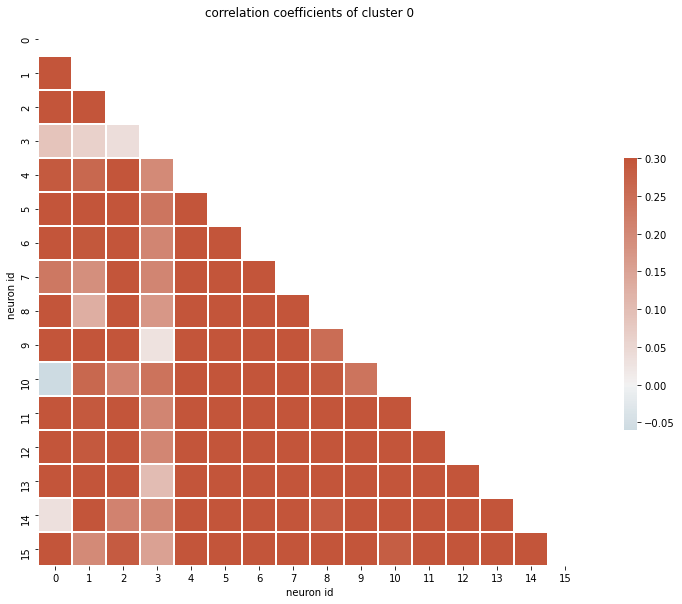

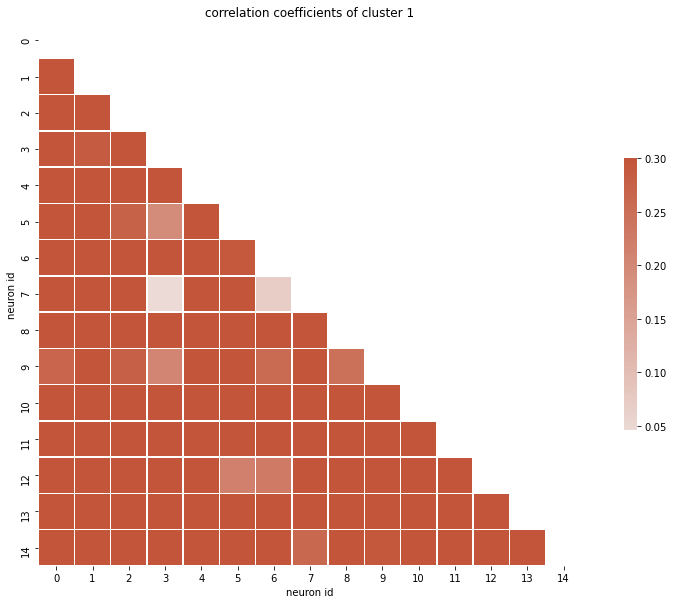

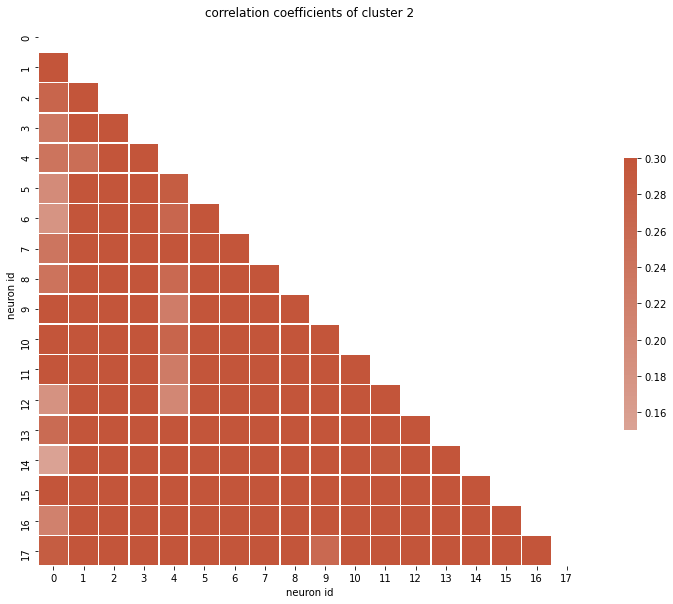

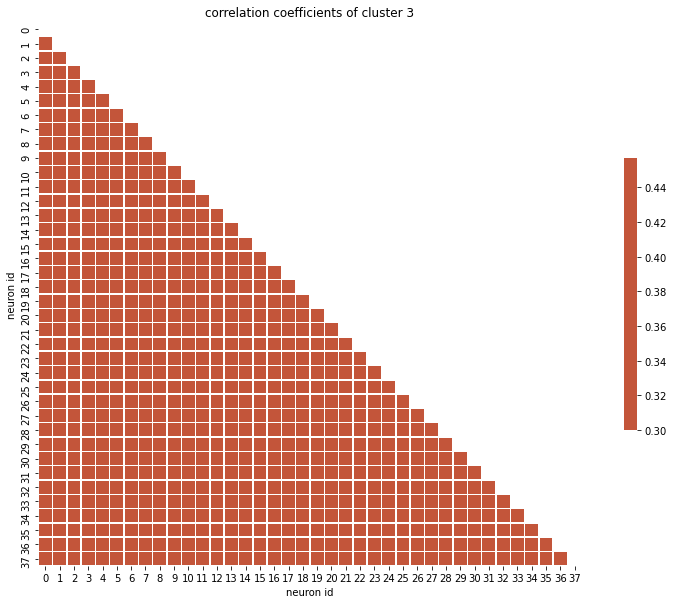

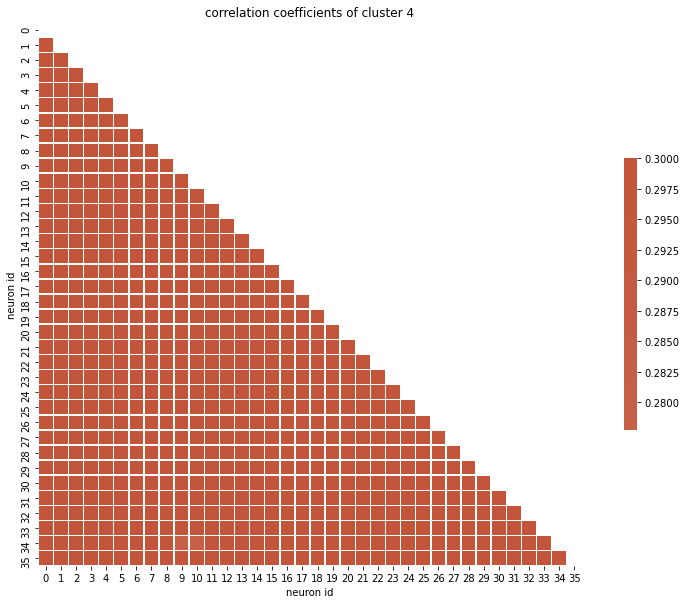

In [17]:

for i in range(len(kmeans_names)):  
    neurons_cluster = np.where(kmeans_labels == kmeans_names[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i),\
                          filename='corr_kmeans{}'.format(i))

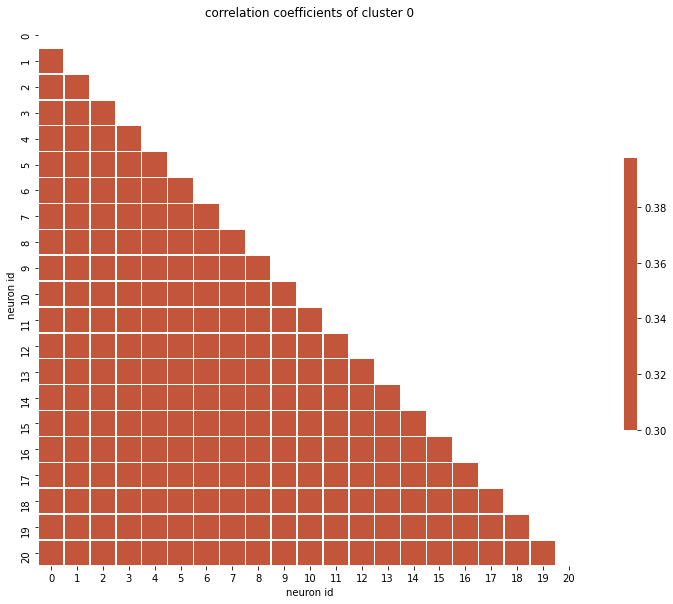

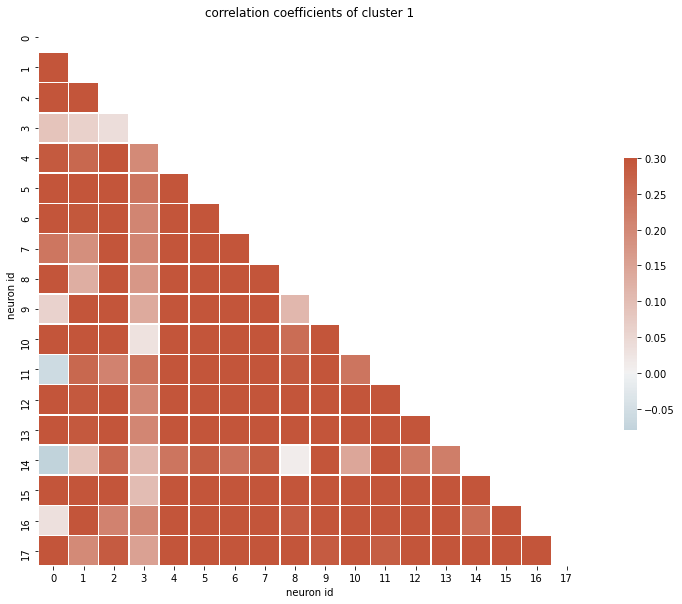

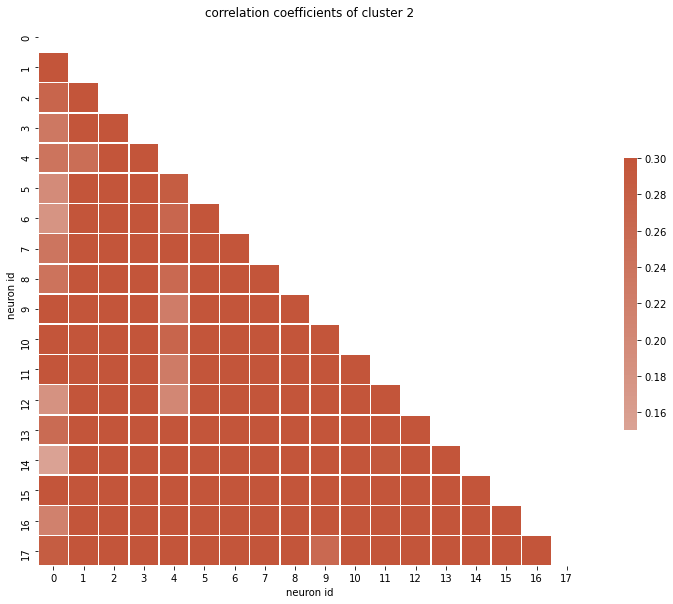

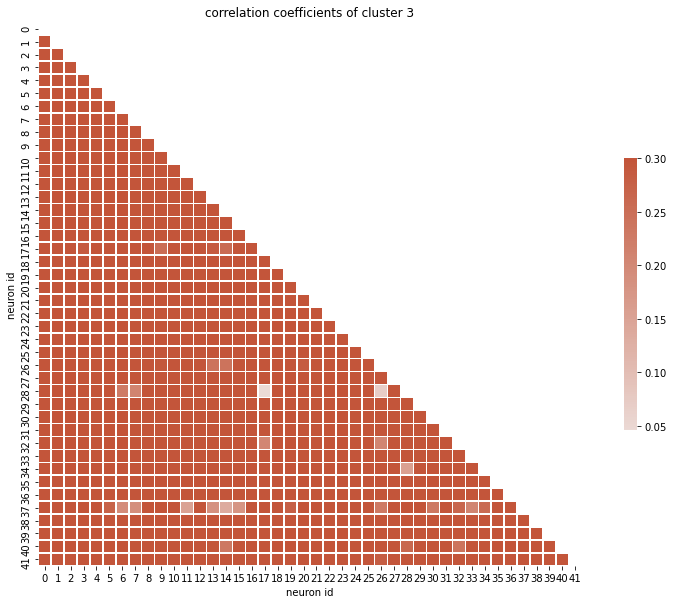

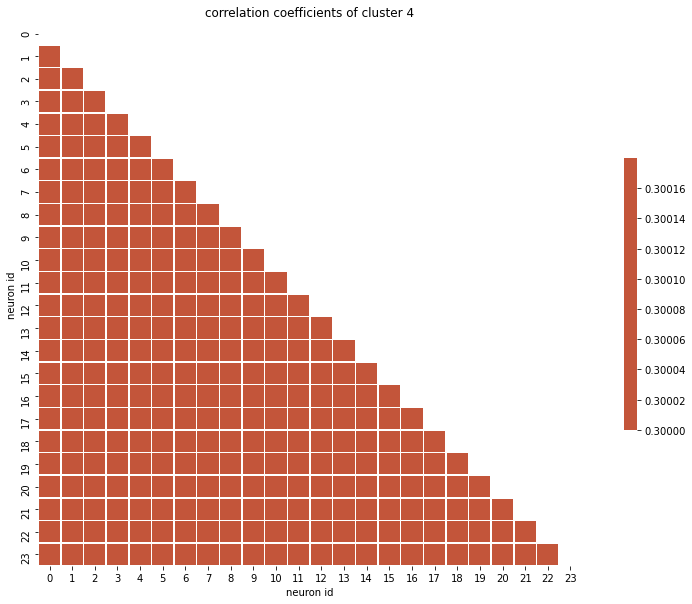

In [16]:
for i in range(len(GMM_names)):  
    neurons_cluster = np.where(GMM_labels == GMM_names[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i),\
                           filename='corr_gmm{}'.format(i))

# 4. Exploratory data analysis


### A. Correlation between neural activity and behaviour

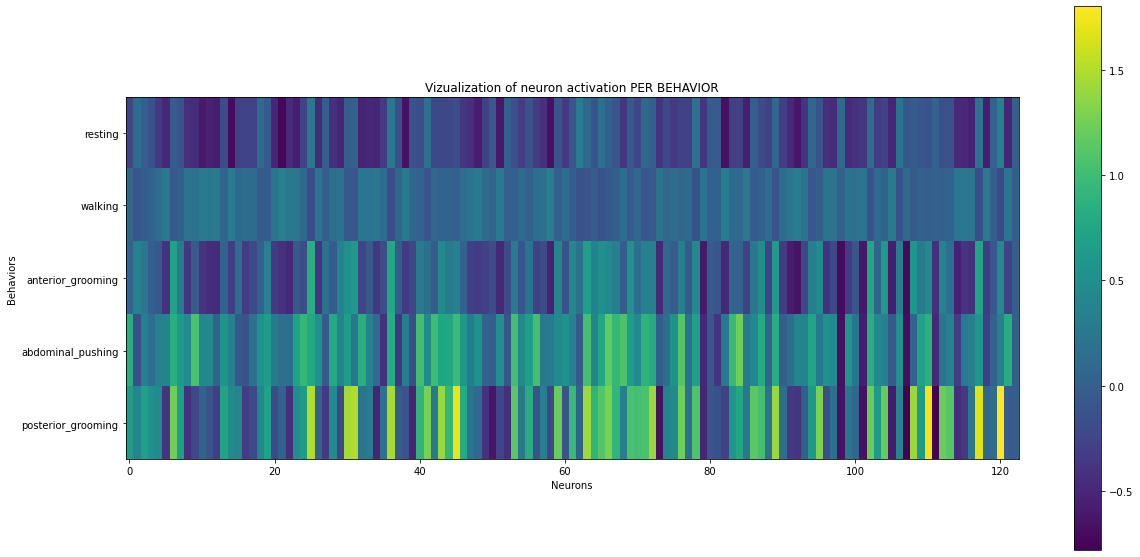

In [19]:
#step1 : standardization
std_Df_f = filtered_neural_df.copy()
for j in np.arange(123): 
    baseline = filtered_neural_df['neuron_' + str(j)].mean()
    std_Df_f['neuron_' + str(j)] = (filtered_neural_df['neuron_' + str(j)]-filtered_neural_df['neuron_' + str(j)].mean())/(filtered_neural_df['neuron_' + str(j)].std())

#step2 : vizualization of neuron activation PER BEHAVIOR
#get manual labelling of behaviors
std_Df_f['Manual'] = filtered_beh_df['Manual']
ytick=[0,1,2,3,4]
val = np.zeros((5,123))

for i in range (len(behaviors)):
    b = behaviors[i]
    behavior_data = std_Df_f[std_Df_f['Manual']==b]
    behavior_data
    for j in range (122):
        val[i,j]=behavior_data['neuron_' + str(j)].mean()

fig, ax2 = plt.subplots(figsize = (20,10))
ax2.set_yticks(ytick)
ax2.set_yticklabels(behaviors)
ax2.set_title('Vizualization of neuron activation PER BEHAVIOR')
ax2.set_ylabel('Behaviors')
ax2.set_xlabel('Neurons')
plt.imshow(val, aspect=10)
plt.colorbar()
plt.show()
fig.savefig('report_images/neuron_act_per_behavior.png')

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

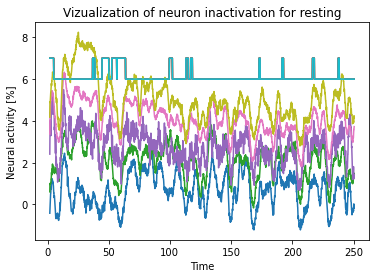

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

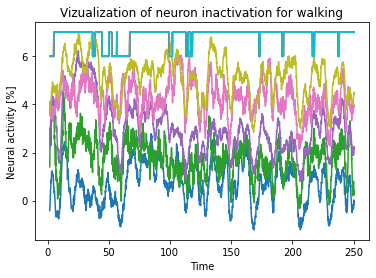

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

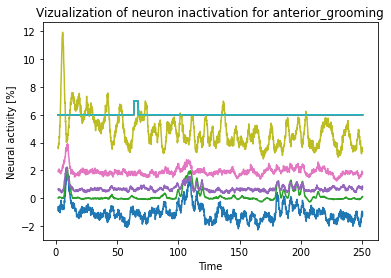

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

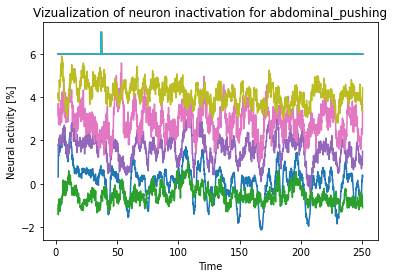

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

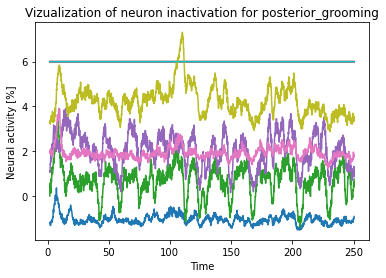

In [20]:
#getting more implicated neurons 
plots_act= val.copy()
nbr_required_neurons=5
neurons= np.zeros((5,nbr_required_neurons))

for i in range (len(behaviors)):
    for j in range (nbr_required_neurons):
        index_max=(np.int_((np.where(abs(plots_act[i])==abs(plots_act[i]).max()))))[0,0]
        neurons[i,j]=index_max
        plots_act[i,index_max]=0
        
neurons=np.int_(neurons)

#try for a specific trial, otherwise it's impossible to read it
try_trial = std_Df_f[std_Df_f.index.get_level_values("Trial")==11].copy(deep=True)
indexs_beh=[]

for i in range (len(neurons)):  
    #try to isolate one behavior for each neuron
    name_fig='fig_beh_'+str(i)
    name_ax='ax_'+str(i)
    name_fig, name_ax = plt.subplots(figsize = (6,4))
    
    for j in range (len(neurons[1])):
        plot_beh=np.zeros((len(try_trial['t'])))
        indexs_beh= np.where(try_trial['Manual']==behaviors[i])
        plot_beh[indexs_beh] = len(neurons[1])+2    
        indexs_= np.where(try_trial['Manual']!=behaviors[i])
        plot_beh[indexs_] = len(neurons[1])+1 
        plt.plot(try_trial['t'], j+hilbert(try_trial['neuron_'+str(neurons[i,j])]))
        plt.plot(try_trial['t'], plot_beh)
    name_ax.set_title('Vizualization of neuron inactivation for ' + behaviors[i])
    name_ax.set_ylabel('Neural activity [%]')
    name_ax.set_xlabel('Time')
    #name_ax.legend('neuron_'+str(neurons[i,0]), 'neuron_'+str(neurons[i,1]))
    plt.show()
    name_fig.savefig('report_images/valuable_neuron_for_'+behaviors[i]+'.png')

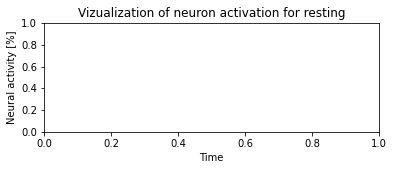

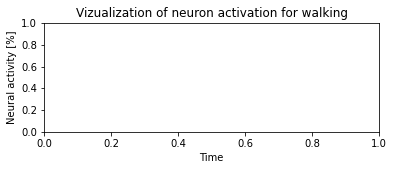

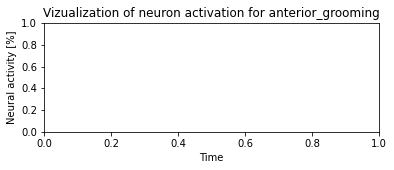

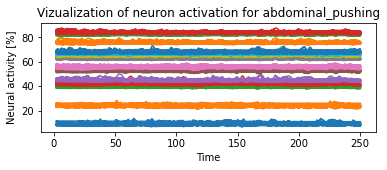

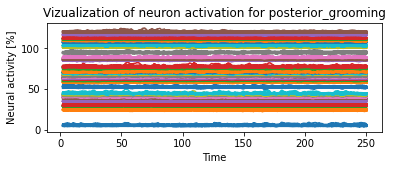

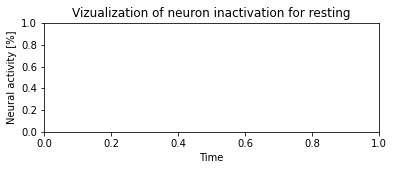

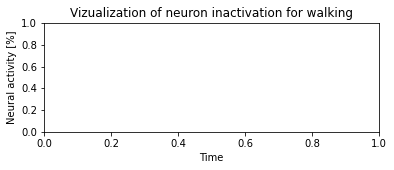

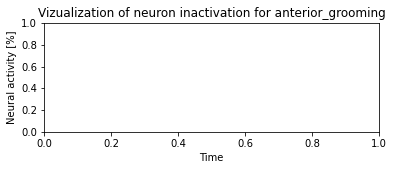

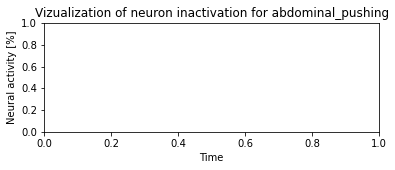

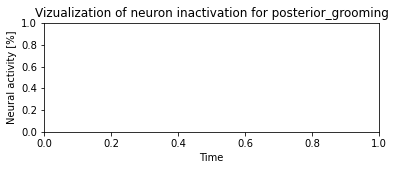

In [21]:
#plots activation for each behaviors
treshold=0.9
#get neurons with anormal activation/unactivation in behaviors
plots_act= val.copy()
plots_inact= val.copy()
for i in range (len(behaviors)):
    for j in range (122):
        if (plots_act[i,j] < treshold):
            plots_act[i,j] = 0
        if (plots_inact[i,j] > -treshold):
            plots_inact[i,j] = 0
            
for i in range (len(behaviors)):  
    #try to isolate one behavior for each neuron
    name_fig='fig_beh_'+str(i)
    name_ax='ax_'+str(i)
    name_fig, name_ax = plt.subplots(figsize = (6,2))

    for j in range (122):
        if plots_act[i,j]>0.0 :
            plt.plot(std_Df_f['t'], std_Df_f['neuron_'+ str(j)]+j)
    name_ax.set_title('Vizualization of neuron activation for ' + behaviors[i])
    name_ax.set_ylabel('Neural activity [%]')
    name_ax.set_xlabel('Time')
    plt.show()

for i in range (len(behaviors)):  
    #try to isolate one behavior for each neuron
    name_fig='fig_beh_'+str(i)
    name_ax='ax_'+str(i)
    name_fig, name_ax = plt.subplots(figsize = (6,2))    
    for j in range (122):
        if plots_inact[i,j]<0.0 :
            plt.plot(std_Df_f['t'], std_Df_f['neuron_'+ str(j)]+j)
    name_ax.set_title('Vizualization of neuron inactivation for ' + behaviors[i])
    name_ax.set_ylabel('Neural activity [%]')
    name_ax.set_xlabel('Time')
    plt.show()

### B. correlation between neural data and behavioral data

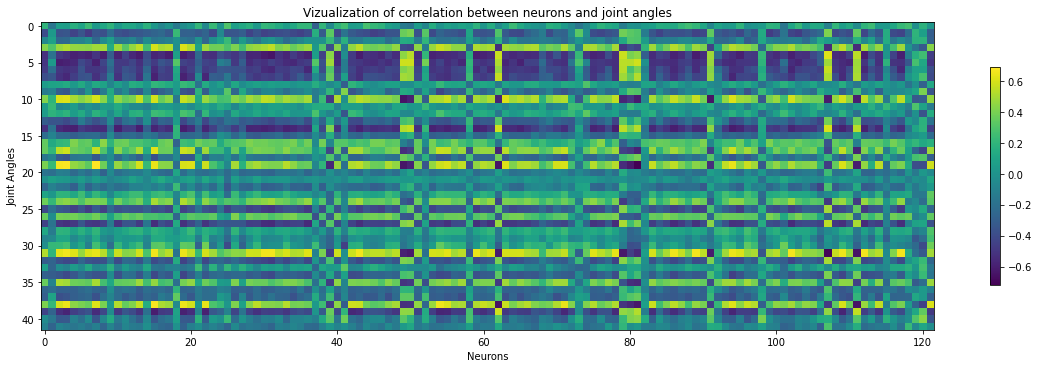

In [22]:
from scipy import stats
nbr_neurons = 122
nbr_beh_param = filtered_beh_df.filter(regex='angle').columns
correlation = np.zeros((len(nbr_beh_param),nbr_neurons))

for j in range (len(nbr_beh_param)): 
    twop_index = filtered_beh_df[filtered_beh_df.index.get_level_values('Trial')==0]['twop_index'].to_numpy()
    values = filtered_beh_df.loc[(210301, 'J1xCI9', 1, 0), nbr_beh_param[j]].to_numpy()
    angl_DS = reduce_during_2p_frame(twop_index, values, function=reduce_mean)  
    for i in range (nbr_neurons) : 
        a=stats.spearmanr(std_Df_f['neuron_'+str(i)][std_Df_f.index.get_level_values('Trial')==0], angl_DS) 
        correlation[j,i]=a[0]
#plot
fig, ax2 = plt.subplots(figsize = (20,40))
ax2.set_title('Vizualization of correlation between neurons and joint angles')
ax2.set_ylabel('Joint Angles')
ax2.set_xlabel('Neurons')
plt.imshow(correlation)
plt.colorbar(shrink=0.1)
plt.show()
fig.savefig('report_images/correlation_btw_joint_angles_&_neuron.png')

### C. Compare clustered neurons from Clustering part (3.B)

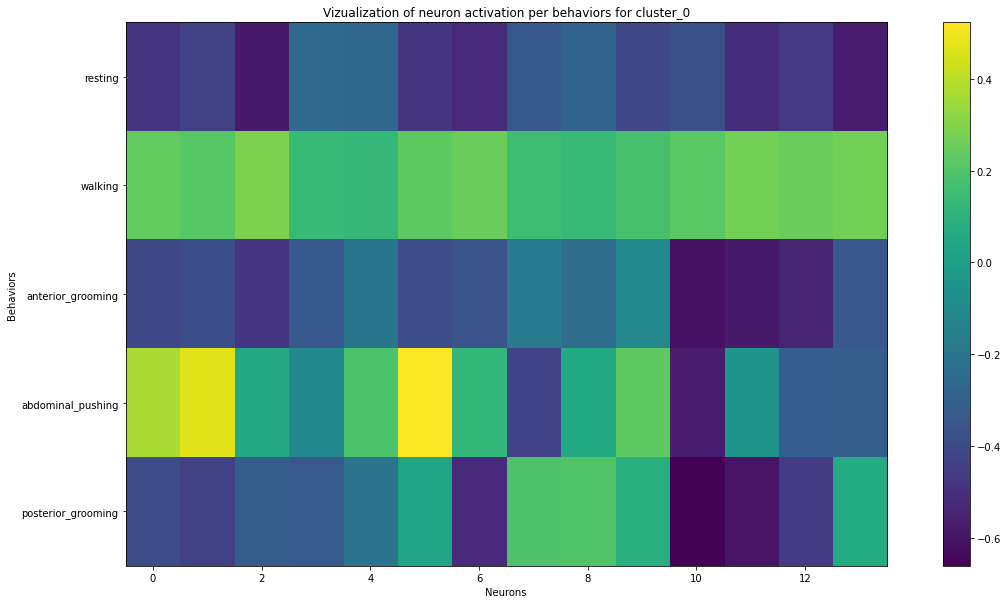

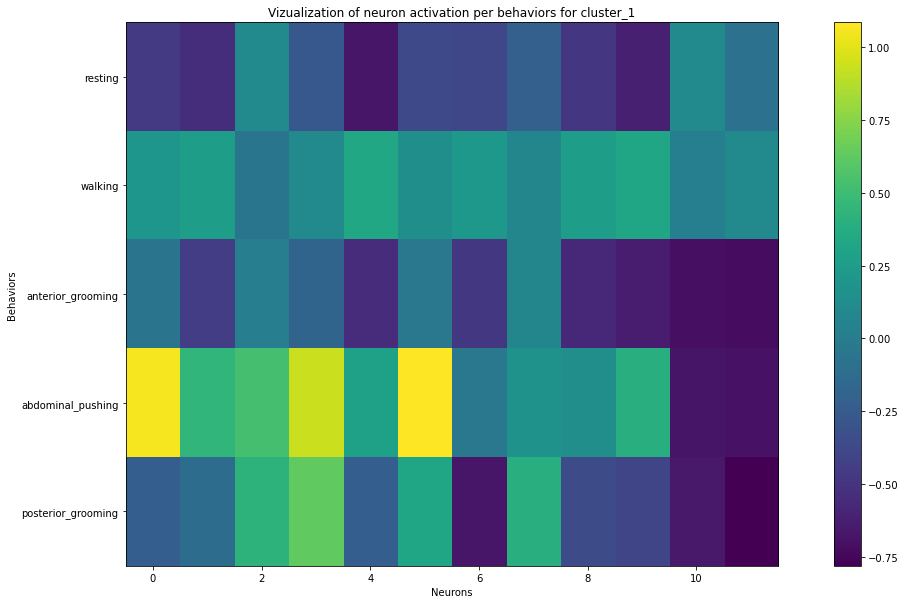

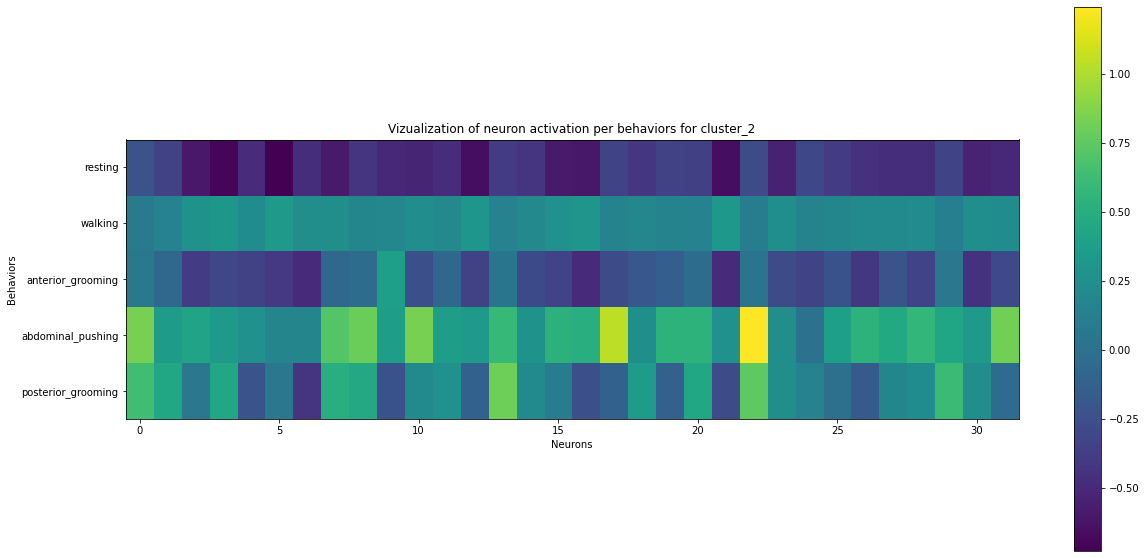

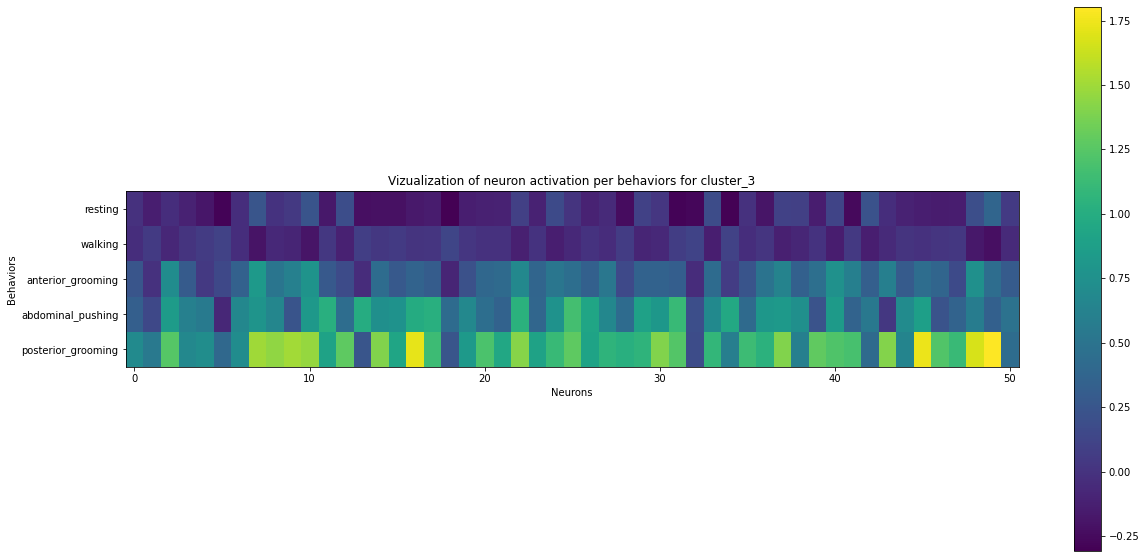

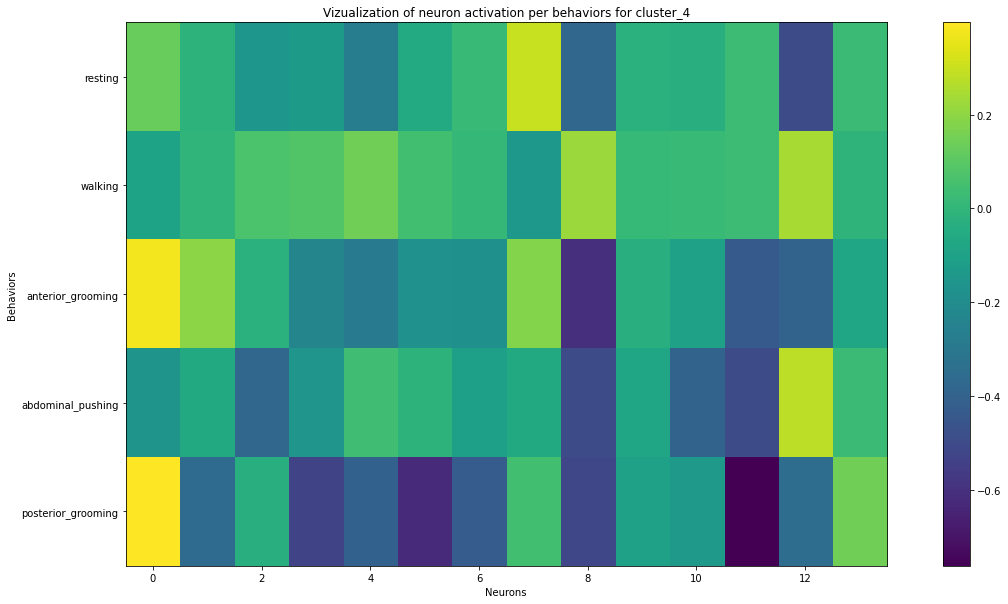

In [23]:
from numpy.linalg import norm
import random
w_norm= kmeans_labels
compare=[]
compare.append([i for i, n in enumerate(w_norm) if n == 0])
compare.append([i for i, n in enumerate(w_norm) if n == 1])
compare.append([i for i, n in enumerate(w_norm) if n == 2])
compare.append([i for i, n in enumerate(w_norm) if n == 3])
compare.append([i for i, n in enumerate(w_norm) if n == 4])

#step2 : vizualization of neuron activation PER BEHAVIOR
#get manual labelling of behaviors
behaviors = ['resting', 'walking', 'anterior_grooming', 'abdominal_pushing', 'posterior_grooming']
ytick=[0,1,2,3,4]

for k in range (5):
    val = np.zeros((5,len(compare[k])))
    i=0
    j=0
    #get corresponding neurons
    for i in range (len(behaviors)):
        behavior_data = std_Df_f[std_Df_f['Manual']==behaviors[i]]
        for j in range (len(val[i])):
            val[i,j] = behavior_data['neuron_' + str(compare[k][j])].mean()
    
    name='fig_cluster_'+str(k)
    name_ax='fig_ax_'+str(k)
    name, name_ax = plt.subplots(figsize = (20,10))
    name_ax.set_yticks(ytick)
    name_ax.set_yticklabels(behaviors)
    name_ax.set_title('Vizualization of neuron activation per behaviors for cluster_'+str(k))
    name_ax.set_ylabel('Behaviors')
    name_ax.set_xlabel('Neurons')
    plt.imshow(val, aspect=2)
    plt.colorbar()
    plt.show()
    name.savefig('report_images/neuron_act_for_cluster_'+str(k)+'.png')

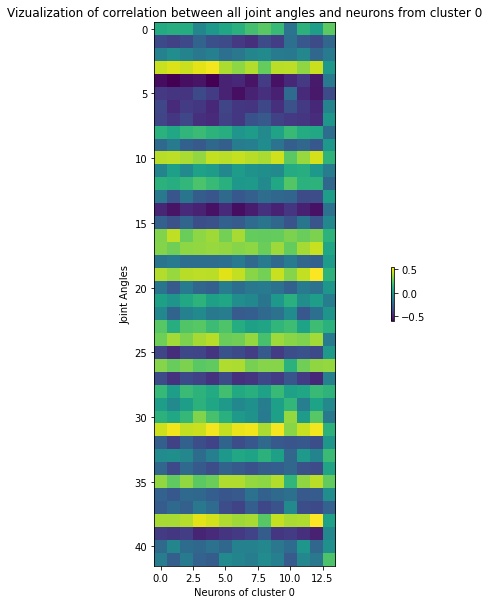

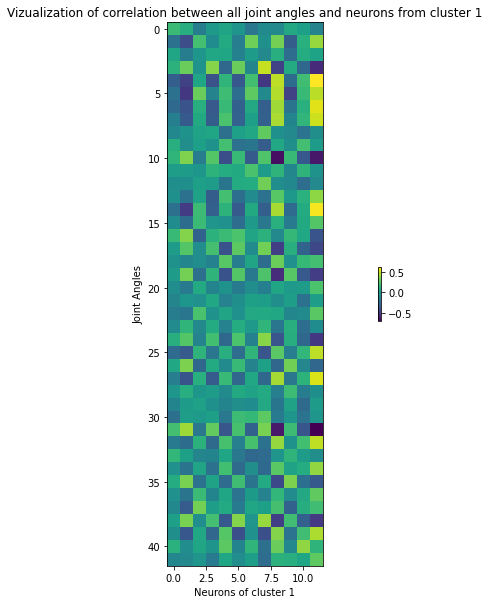

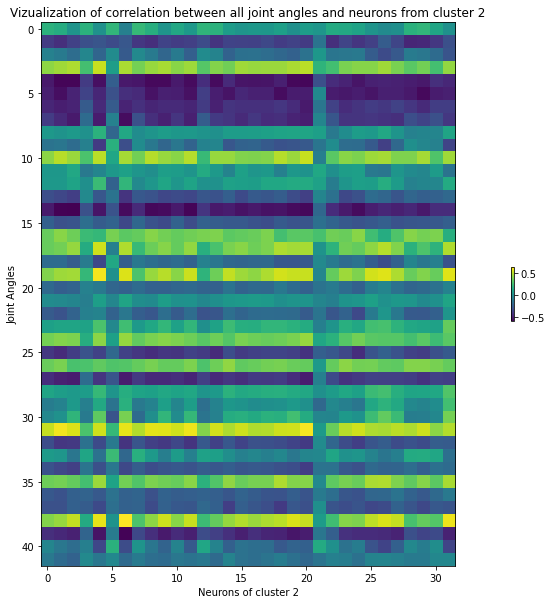

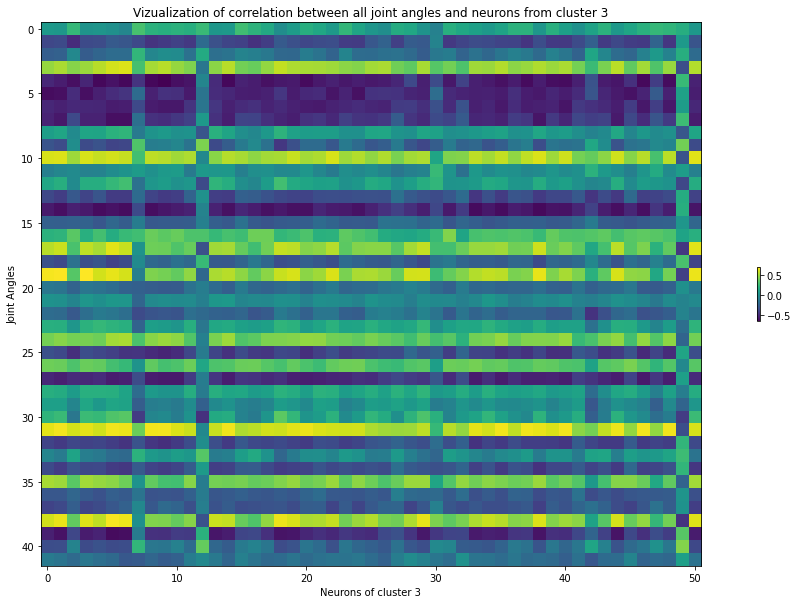

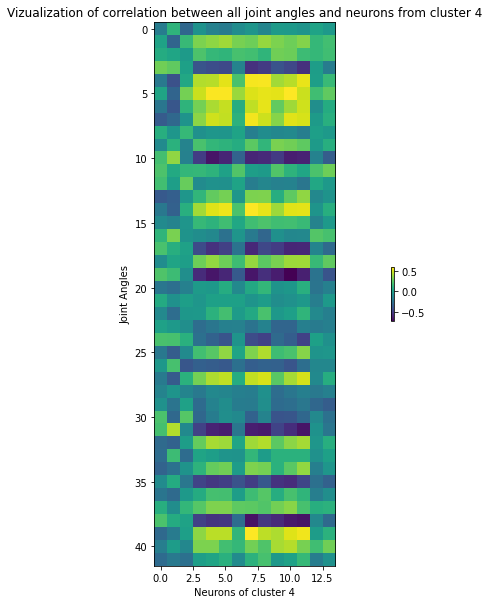

In [24]:
#step2 : vizualization of neuron activation PER BEHAVIOR
#get manual labelling of behaviors
from scipy import stats

for k in range (5):
    val = np.zeros((5,len(compare[k])))
    
    ### correlation between neural data and behavioral data
    nbr_beh_param = filtered_beh_df.filter(regex='angle').columns
    correlation = np.zeros((len(nbr_beh_param),len(compare[k])))

    #DONE ONLY FOR TRIAL 0
    for i in range (len(nbr_beh_param)): 
        twop_index = filtered_beh_df[filtered_beh_df.index.get_level_values('Trial')==0]['twop_index'].to_numpy()
        values = filtered_beh_df.loc[(210301, 'J1xCI9', 1, 0), nbr_beh_param[i]].to_numpy()
        angl_DS = reduce_during_2p_frame(twop_index, values, function=reduce_mean)  
        for j in range (len(compare[k])) : 
            a=stats.spearmanr(std_Df_f['neuron_'+str(compare[k][j])][std_Df_f.index.get_level_values('Trial')==0], angl_DS) 
            correlation[i,j]=a[0]
    #plot
    name='fig_cluster_'+str(k)
    name_ax='fig_ax_'+str(k)
    name, name_ax = plt.subplots(figsize = (20,10))
    name_ax.set_title('Vizualization of correlation between all joint angles and neurons from cluster '+str(k))
    name_ax.set_ylabel('Joint Angles')
    name_ax.set_xlabel('Neurons of cluster '+str(k))
    plt.imshow(correlation)
    plt.colorbar(shrink=0.1)
    plt.show()
    name.savefig('report_images/corr_btw_joint_angles_neuron_cluster'+str(k)+'.png')

# 5. Classifying behavior from behavioral data

Here we attemp to predict behavior from joint angles.

### A. Wavelet Transfrom
The wavelet transform is used to add dynamic information to the data. This adds features according to the frequency of the signals.

In [39]:
# Perform wavelet transform on all joint angles
angles = filtered_beh_df.filter(regex="angle")
manual_labels = filtered_beh_df.filter(regex="Manual")

# Standardize the data using the function from section 3A
angles_norm = standardize(angles)

nb_freqs = 25

freqs, power, beh_wave = wavelet_transform(np.array(angles_norm), n_freqs=nb_freqs, fsample=100., fmin=1., fmax=50.)


Here we plot the frequency components returned by wavelet transform, for time samples with walking and resting. The x-axis is a mixture of samples and does not have a continuous time meaning

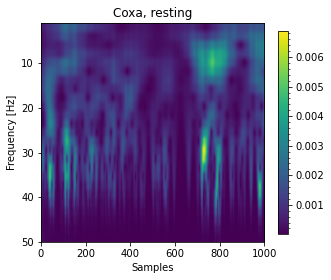

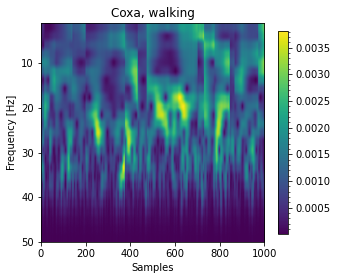

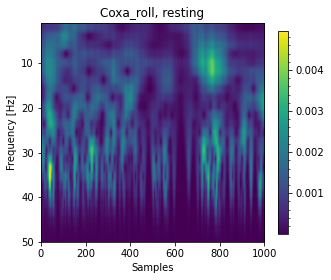

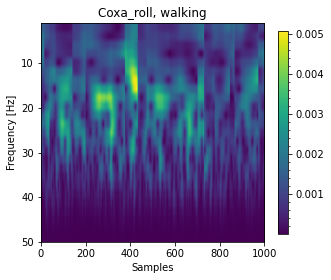

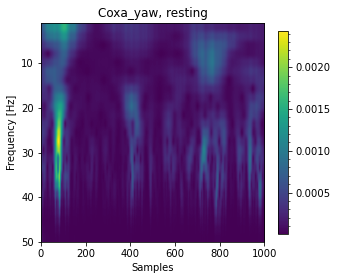

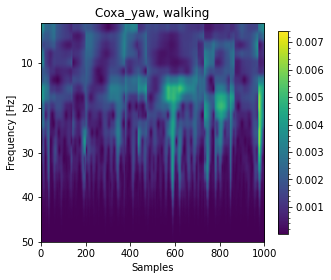

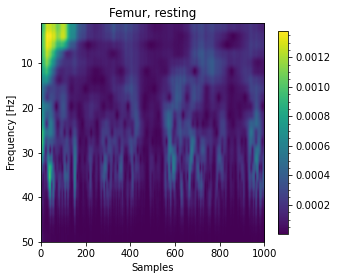

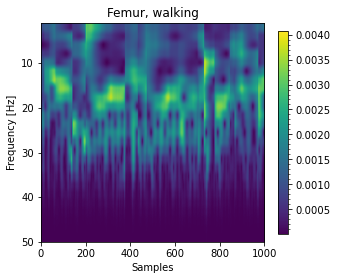

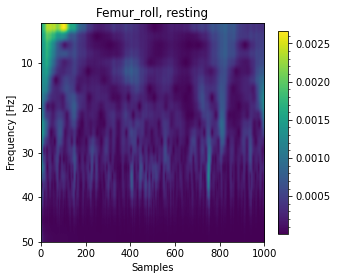

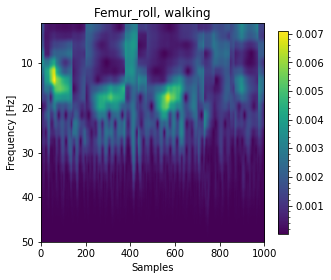

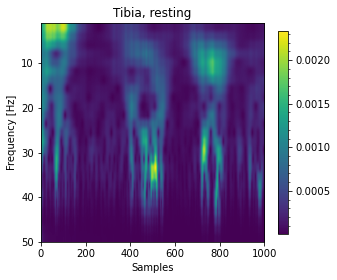

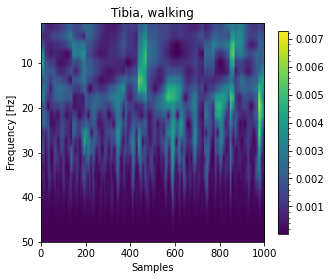

In [40]:
# Plot frequency components returned by wavelet transform, split into resting and walking

# for first 6 angles (front right leg)
for i in np.arange(6):
    
    # for two behavior types (resting, walking)
    for j in np.arange(2):
        fig, ax = plt.subplots(figsize = (5,5))
        start_id = i*nb_freqs
        select_indices = np.where(manual_labels == behaviors[j])[0]        
        
        im = plt.imshow(beh_wave.T[start_id:start_id+nb_freqs,select_indices[0:1000]], aspect=20, \
                        extent=[0,1000,50,1])
        plt.title(joints[i] + ', '+ behaviors[j])
        plt.xlabel('Samples')
        plt.ylabel('Frequency [Hz]')
        cbar = fig.colorbar(im, shrink=0.75)
        cbar.minorticks_on()
        
        fig.savefig('report_images/wavelet_' + joints[i] + '_'+ behaviors[j]+'.png')
        

### B. PCA on augmented data
We plot the augmented joint angles projected onto the first two PCA components

In [47]:
# plot 2 dimensional data, with color for each behavioral label
def plot_2D_beh_labels(data, manual_labels, labels_list, dim1, dim2):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))

    for i in np.arange(len(labels_list)):
        select_indices = np.where(manual_labels == labels_list[i])
        plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.2)  
    
    plt.title('PCA projected joint angles')
    ax.set_xlabel('feature' + str(dim1))

    ax.set_ylabel('feature' + str(dim2))

    ax.legend(labels_list)
    fig.savefig('report_images/wavelet_pca.png')

[0.14311188 0.09838448 0.04758655 0.03705521 0.0317808 ]


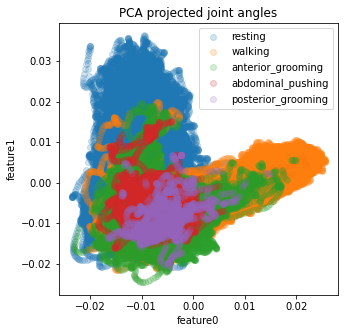

In [48]:
# PCA on augmented data
pca_angles = PCA(n_components=5)
beh_new = pca_angles.fit_transform(beh_wave)
print(pca_angles.explained_variance_ratio_)

plot_2D_beh_labels(beh_new[:,0:2], manual_labels, behaviors, 0, 1)